# Wire Image Data

## Purpose of this notebook

This notebook provides an example for visualizing the recorded data in each event as a set of images, one per TPC plane. The image can be used for visual data processing, such as convolutional neural networks. Recent examples from MicroBooNE are “Semantic Segmentation with a Sparse Convolutional Neural Network for Event Reconstruction in MicroBooNE”, arXiv:2012.08513, Phys. Rev. D103, 052012 (2021) and ”A Convolutional Neural Network for Multiple Particle Identification in the MicroBooNE Liquid Argon Time Projection Chamber”, arXiv:2010.08653, Phys. Rev. D103, 092003 (2021). 

In order to use this notebook, samples labeled as "with Wire" need to be used; due to large size of the Wire waveform information, these are samples with reduced number of events. The 2D image shows the time (in TPC clock ticks) vs the wire number, and the color scale is the wire waveform amplitude at each tick in ADC units. Larger ADC values mean larger deposited charge.

Ground truth information with resolution of image pixels is not provided, as it would further increase the size of the sample. However, as shown in the "Hit Labeling.ipynb" notebook, we provide tools to produce ground truth information from hits that have the same 2D structure of these images and thus can be used to define the image ground truth. For instance, one can check if a non-zero pixel lies on the same wire and within `±n*rms` of the `local_time` of a hit, and in that case assign to the pixel the same label as the hit. An example of how to do this will be demostrated in this notebook.

## Load useful libraries, utilities, and data

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from microboone_utils import *

In [25]:
from h5py import File
f = File('/home/gabriel/Downloads/bnb_WithWire_00.h5','r')

In [26]:
tables = ['event_table','wire_table','hit_table','edep_table']
data_tables=[]
for a in tables:
    data_tables.append(f[a])

evts = data_tables[0]['event_id'][:]   #ordem --> run,subrun e event??

In [27]:
with open("labels.txt", "w") as file:
    for lines in f:
        file.write(lines)
        file.write("\n")
        for key in f[lines]:
            file.write("\t")
            file.write(key)
            file.write("\n") 


In [28]:
events_data=data_tables[0]
wire_data=data_tables[1]
hits_data = data_tables[2]
edeps_data = data_tables[3]

for key in wire_data.keys():
     print(wire_data,key)

for key in edeps_data.keys():
    print(edeps_data,key)
    
for key in hits_data.keys():
    print(hits_data,key)

<HDF5 group "/wire_table" (6 members)> adc
<HDF5 group "/wire_table" (6 members)> event_id
<HDF5 group "/wire_table" (6 members)> event_id.seq_cnt
<HDF5 group "/wire_table" (6 members)> local_plane
<HDF5 group "/wire_table" (6 members)> local_wire
<HDF5 group "/wire_table" (6 members)> tpc
<HDF5 group "/edep_table" (6 members)> energy
<HDF5 group "/edep_table" (6 members)> energy_fraction
<HDF5 group "/edep_table" (6 members)> event_id
<HDF5 group "/edep_table" (6 members)> event_id.seq_cnt
<HDF5 group "/edep_table" (6 members)> g4_id
<HDF5 group "/edep_table" (6 members)> hit_id
<HDF5 group "/hit_table" (9 members)> event_id
<HDF5 group "/hit_table" (9 members)> event_id.seq_cnt
<HDF5 group "/hit_table" (9 members)> hit_id
<HDF5 group "/hit_table" (9 members)> integral
<HDF5 group "/hit_table" (9 members)> local_plane
<HDF5 group "/hit_table" (9 members)> local_time
<HDF5 group "/hit_table" (9 members)> local_wire
<HDF5 group "/hit_table" (9 members)> rms
<HDF5 group "/hit_table" (9 m

## Extract the Wire information for one event and produce the image

Select the event and print the event_id

In [29]:
evt = evts[1]
evt_id = [evt[0],evt[1],evt[2]]
print('Going to produce wire image for event:',evt_id)

Going to produce wire image for event: [7004, 331, 16552]


Extract wire information for this specific event, and get the wire readouts (ADC) for the different planes

In [30]:
max=100000
wire_table=data_tables[1]
event_wire_plan=wire_table["event_id"][0:max-1]
local_plane = wire_table["local_plane"][0:max-1]
adc=wire_table["adc"][0:max-1]

In [31]:
boolean_index = event_wire_plan == evt
boolean_index_2=[]
for aux in range(len(boolean_index)):
    if boolean_index[aux][0] and boolean_index[aux][1] and boolean_index[aux][2]:
        boolean_index_2.append(True)
    else:
        boolean_index_2.append(False)

In [32]:
local_plane = local_plane[boolean_index_2]#preciso filtrar so para o que aparece
adc=adc[boolean_index_2]

In [33]:
planeadcs=[]
for aux in range(0,nplanes()):
    local_plane_index=local_plane==aux
    local_plane_index_2=[]
    for aux2 in range(len(local_plane_index)):
        local_plane_index_2.append(local_plane_index[aux2][0])
    planeadcs.append(adc[local_plane_index_2][:])


In [34]:
planeadcs[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Print information about the number of wires and ACD reads (waveform amplitude at each time tick)

In [35]:
print("number of plane 0 wires=",len(planeadcs[0]))
print("number of plane 1 wires=",len(planeadcs[1]))
print("number of plane 2 wires=",len(planeadcs[2]))
print("number of ADC reads=",len(planeadcs[0][0]))
aspratio = len(planeadcs[2])/len(planeadcs[1])
print("plane2 vs plane0/1 aspect ratio = ",aspratio)

number of plane 0 wires= 2400
number of plane 1 wires= 2400
number of plane 2 wires= 3456
number of ADC reads= 6400
plane2 vs plane0/1 aspect ratio =  1.44


Now, let's downsample the data in the time coordinate (it may be useful for memory saving purposes) by a factor `f_downsample` (set to 2 in this example). The value in the resampling interval are summed, so we effectively move from ADC value to a pixel intensity defined as a sum of ADC values. We can plot the ADC sums and then define a cutoff value, with values below it assumed to be noise and thus set to zero, and a saturation point, where values above are set to it. Note that both the cutoff and saturation values depend on the resampling factor.

In [36]:
from skimage.measure import block_reduce

In [37]:
f_downsample = 6
for p in range(0,nplanes()):
    planeadcs[p] = block_reduce(planeadcs[p], block_size=(1,f_downsample), func=np.sum)

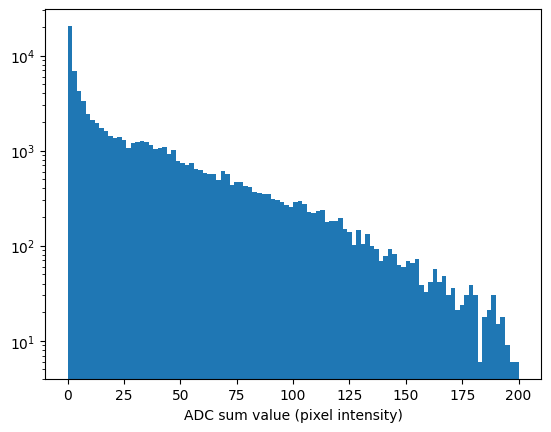

In [38]:
adcsgt0 = [i[i>0] for i in planeadcs[p] for p in range(0,nplanes())]
flat_adcs = [item for sublist in adcsgt0 for item in sublist]
plt.hist(flat_adcs,bins=np.linspace(0,200.*f_downsample/6.,101))
plt.yscale('log')
plt.xlabel('ADC sum value (pixel intensity)')
plt.show()

In [39]:
adccutoff = 10.*f_downsample/6.
adcsaturation = 100.*f_downsample/6.
for p in range(0,nplanes()):
    planeadcs[p][planeadcs[p]<adccutoff] = 0
    planeadcs[p][planeadcs[p]>adcsaturation] = adcsaturation

Let's make the image now for each plane as time tick vs wire number, color-coded based on the ADC sum value.

In [40]:
zmax = adcsaturation

print("Run / Sub / Event : %i / %i / %i - saturation set to ADC sum=%.2f"%(evt_id[0],evt_id[1],evt_id[2],zmax))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), dpi=600)

im1 = ax1.imshow(planeadcs[0].T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax1.set_title("Plane 0")
ax1.set_xlabel("Wire")
ax1.set_ylabel("Time Tick")

im2 = ax2.imshow(planeadcs[1].T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax2.set_title("Plane 1")
ax2.set_xlabel("Wire")

im3 = ax3.imshow(planeadcs[2].T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax3.set_title("Plane 2")
ax3.set_xlabel("Wire")

plt.tight_layout()

Run / Sub / Event : 7004 / 331 / 16552 - saturation set to ADC sum=100.00


## Extract ground truth and convert into image format

Get the ground truth from hits and energy deposition tables.

In [41]:
import pandas as pd
hits_data = data_tables[2]
edeps_data = data_tables[3]

event_id=(edeps_data["event_id"][0:max-1])
boolean_index = event_id == evt
boolean_index_2=[]
for aux in range(len(boolean_index)):
    if boolean_index[aux][0] and boolean_index[aux][1] and boolean_index[aux][2]:
        boolean_index_2.append(True)
    else:
        boolean_index_2.append(False)

energy_fraction=(edeps_data["energy_fraction"][0:max-1])[boolean_index_2]
hit_id=(edeps_data["hit_id"][0:max-1])[boolean_index_2]
g4_id=(edeps_data["g4_id"][0:max-1])[boolean_index_2]

boolean_index = event_wire_plan == evt
boolean_index_2=[]
for aux in range(len(boolean_index)):
    if boolean_index[aux][0] and boolean_index[aux][1] and boolean_index[aux][2]:
        boolean_index_2.append(True)
    else:
        boolean_index_2.append(False)

edeps_panda=pd.DataFrame({
    'energy_fraction': energy_fraction.flatten(),
    'hit_id': hit_id.flatten(),
    'g4_id': g4_id.flatten()
})


event_id=(hits_data["event_id"][0:max-1])
boolean_index = event_id == evt
boolean_index_2=[]
for aux in range(len(boolean_index)):
    if boolean_index[aux][0] and boolean_index[aux][1] and boolean_index[aux][2]:
        boolean_index_2.append(True)
    else:
        boolean_index_2.append(False)

hit_id=hits_data["hit_id"][0:max-1][boolean_index_2]
local_plane=hits_data["local_plane"][0:max-1][boolean_index_2]
local_time=hits_data["local_time"][0:max-1][boolean_index_2]
local_wire=hits_data["local_wire"][0:max-1][boolean_index_2]
rms=hits_data["rms"][0:max-1][boolean_index_2]
hits_panda=pd.DataFrame({
    'hit_id': hit_id.flatten(),
    'local_plane': local_plane.flatten(),
    'local_time': local_time.flatten(),
    'local_wire': local_wire.flatten(),
    'rms': rms.flatten(),
})


edeps = edeps_panda.sort_values(by=['energy_fraction'], ascending=False, kind='mergesort').drop_duplicates(["hit_id"])
hits = hits_panda.merge(edeps, on=["hit_id"], how="left")
hits['g4_id'] = hits['g4_id'].fillna(-1)
hits = hits.fillna(0)
hits 



,hit_id,local_plane,local_time,local_wire,rms,energy_fraction,g4_id
0,0,0,903.091797,0,2.488400,0.0,-1.0
1,1,0,910.019897,0,4.152784,0.0,-1.0
2,2,0,2006.532471,0,3.619054,0.0,-1.0
3,3,0,3721.667969,0,5.285796,0.0,-1.0
4,4,0,5921.445312,0,2.916591,0.0,-1.0
...,...,...,...,...,...,...,...
19089,19089,2,5214.856445,3450,2.845015,0.0,-1.0
19090,19090,2,5215.486816,3451,2.816978,0.0,-1.0
19091,19091,2,5215.805176,3452,3.027444,0.0,-1.0
19092,19092,2,5217.264648,3453,2.920720,0.0,-1.0


In [42]:
print(len(g4_id.flatten()))

2044


Now we define the ground truth per non-zero pixel. We assign a truth value of `+1` to the pixels that are within a window around the time of a hit from the neutrino interaction (window size defined in terms of `n` times the hit time RMS: `nrms`, set to 2 in this example) , and a value of `-1` for those around the time of a cosmic-induced hit. We use this information to produce a ground truth image.

In [43]:
from math import floor, ceil

In [44]:
planetruth = [np.zeros(shape=(nwires(p),ntimeticks())) for p in range(0,nplanes())]

nrms = 2
for p in range(0,nplanes()):
    nuhits = hits.query('local_plane==%i and g4_id>=0'%p)[['local_wire','local_time','rms']]
    #print(nuhits)
    for i,h in nuhits.iterrows():
        planetruth[p][int(h['local_wire'])][floor(h['local_time']-nrms*h['rms']):ceil(h['local_time']+nrms*h['rms'])] = 1
    cosmhits = hits.query('local_plane==%i and g4_id<0'%p)[['local_wire','local_time','rms']]
    for i,h in cosmhits.iterrows():
        planetruth[p][int(h['local_wire'])][floor(h['local_time']-nrms*h['rms']):ceil(h['local_time']+nrms*h['rms'])] = -1

for p in range(0,nplanes()):
    planetruth[p] = block_reduce(planetruth[p], block_size=(1,f_downsample), func=np.sum)

for p in range(0,nplanes()):
    planetruth[p] = np.multiply(planetruth[p],planeadcs[p])

In [45]:
cosmhits

,local_wire,local_time,rms
14595,2,1859.483643,2.663851
14596,3,1862.487061,3.425622
14597,4,1860.802002,3.611362
14598,5,1872.895020,4.504058
14599,6,1885.371460,4.241106
...,...,...,...
19089,3450,5214.856445,2.845015
19090,3451,5215.486816,2.816978
19091,3452,5215.805176,3.027444
19092,3453,5217.264648,2.920720


In [46]:
nuhits

,local_wire,local_time,rms
16847,1446,3690.280518,7.093081
16848,1447,3680.921631,6.909979
16948,1546,2922.108398,4.541143
16949,1547,2916.538086,4.871610
16950,1548,2911.551514,4.927672
...,...,...,...
17680,2054,2584.257080,3.643610
17683,2055,2582.055176,3.616456
17687,2056,2579.802490,3.634216
17690,2057,2577.681885,3.648571


In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), dpi=600)

im1 = ax1.imshow(planetruth[0].T,vmin=-1,vmax=1,origin='lower',cmap='coolwarm')
ax1.set_title("Plane 0")
ax1.set_xlabel("Wire")
ax1.set_ylabel("Time Tick")

im2 = ax2.imshow(planetruth[1].T,vmin=-1,vmax=1,origin='lower',cmap='coolwarm')
ax2.set_title("Plane 1")
ax2.set_xlabel("Wire")

im3 = ax3.imshow(planetruth[2].T,vmin=-1,vmax=1,origin='lower',cmap='coolwarm')
ax3.set_title("Plane 2")
ax3.set_xlabel("Wire")

plt.tight_layout()